# Filtrage et convolution pour la détection des caractéristiques

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
import math
from scipy import ndimage 
from scipy.signal import convolve2d

In [2]:
def matrices_xy(image, filtre):

    if filtre == 'Prewitt':
        # Le filtre Prewitt
        filtre_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
        filtre_y = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])
    elif filtre == 'Sobel':
        # Le filtre Sobel
        filtre_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
        filtre_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    elif filtre == 'Laplacien':
        # Le filtre Laplacien
        filtre_x = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
        filtre_y = np.array([[1, 1, 1], [1, 8, 1], [1, 1, 1]])

    mx = np.zeros((image.shape[0], image.shape[1]))
    my = np.zeros((image.shape[0], image.shape[1]))

    # Appliquer les filtres Prewitt pour détecter les contours dans les directions X et Y
    for i in range(1, image.shape[0]-1):
        for j in range(1, image.shape[1]-1):
            tmp = np.array([[image[i-1, j-1], image[i-1, j], image[i-1, j+1]]
                            , [image[i, j-1], image[i, j], image[i, j+1]]
                            , [image[i+1, j-1], image[i+1, j], image[i+1, j+1]]])
            mx[i][j] = abs(np.sum(tmp * filtre_x))
            my[i][j] = abs(np.sum(tmp * filtre_y))
            
    return(mx, my)

In [3]:
def image_contours_filtre(image, filtre, seuil):
    # Image contour
    contours = np.zeros((image.shape[0], image.shape[1]))
    mx, my = matrices_xy(image, filtre)
    for i in range(1, image.shape[0]-1):
        for j in range(1, image.shape[1]-1):
            contours[i][j] = 1 if (mx[i][j] or my[i][j]) >= seuil else 0
    return(contours)

### Détection de contours des triangles du AIIP_1, Partie 1(a) par le filtre Prewitt.

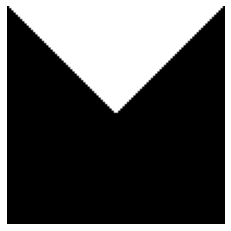

In [4]:
n = 100

image = np.zeros((n, n))

for i in range(int(n/2)):
    for j in range(int(n/2)):
        if i < j : 
            image[i, j] = 1 
            image[i, n-j-1] = 1 

plt.axis('off')  # Désactive les axes
plt.imshow(image, cmap='gray')
plt.savefig('img/triangle1.png')

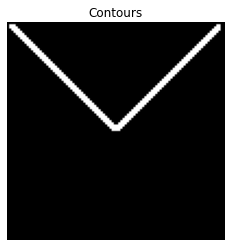

<Figure size 432x288 with 0 Axes>

In [5]:
seuil = 1
im_contours = image_contours_filtre(image, 'Prewitt',seuil)
# Afficher l'image des contours à l'aide de matplotlib
plt.imshow(im_contours, cmap='gray')
plt.title('Contours')
plt.axis('off')  # Masquer les axes
plt.show()
plt.savefig('img/contours_triangle1.png')

### Détection de contours de l’image dans le fichier « lena.jpg » par le filtre Sobel.

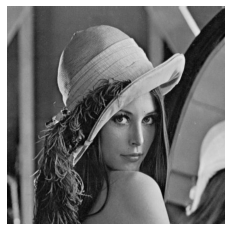

In [4]:
image_lena = np.array(Image.open('img/lena.jpg').convert('L'))

plt.axis('off')  # Désactive les axes
plt.imshow(image_lena, cmap='gray')

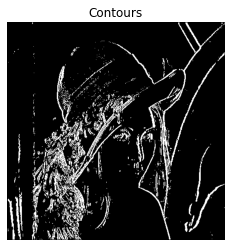

<Figure size 432x288 with 0 Axes>

In [5]:
seuil = 100
im_contours_lena = image_contours_filtre(image_lena, 'Sobel',seuil)
# Afficher l'image des contours à l'aide de matplotlib
plt.imshow(im_contours_lena, cmap='gray')
plt.title('Contours')
plt.axis('off')  # Masquer les axes
plt.show()
plt.savefig('img/contours_lena.png')

### Varier les seuils, puis observer et expliquer les résultats obtenus avec différents seuils : seuil fort et seuil faible

In [21]:
seuil_1 = 50
seuil_2 = 100
seuil_3 = 200

im_contours_lena_1 = image_contours_filtre(image_lena, 'Sobel',seuil_1)
im_contours_lena_2 = image_contours_filtre(image_lena, 'Sobel',seuil_2)
im_contours_lena_3 = image_contours_filtre(image_lena, 'Sobel',seuil_3)

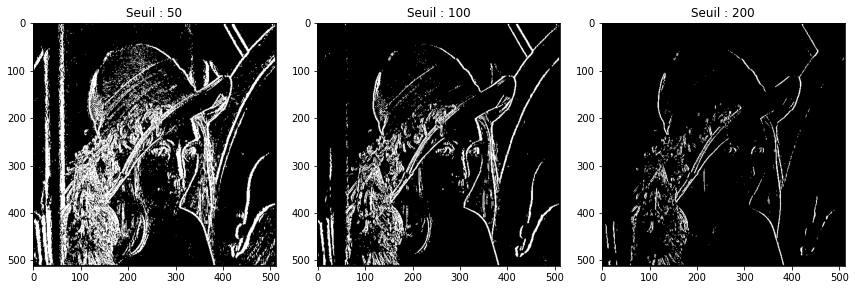

In [22]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(im_contours_lena_1, cmap='gray')
plt.title("Seuil : " + str(seuil_1))
plt.axis('off')  # Désactive les axes

plt.subplot(1, 3, 2)
plt.imshow(im_contours_lena_2, cmap='gray')
plt.title("Seuil : " +  str(seuil_2))
plt.axis('off')  # Désactive les axes

plt.subplot(1, 3, 3)
plt.imshow(im_contours_lena_3, cmap='gray')
plt.title("Seuil : " + str(seuil_3))
plt.axis('off')  # Désactive les axes

plt.tight_layout()
plt.show()

### Détection de contours par le seuillage hystérésis (algorithme et programme)

In [14]:
def matrices_gradient(image):
    Ix = np.zeros((image.shape[0], image.shape[1]))
    Iy = np.zeros((image.shape[0], image.shape[1]))
    Ig = np.zeros((image.shape[0], image.shape[1]))

    filtre_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
    filtre_y = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])

    # Appliquer les filtres Prewitt pour détecter les contours dans les directions X et Y
    for i in range(1, image.shape[0]-1):
        for j in range(1, image.shape[1]-1):
            tmp = np.array([[image[i-1, j-1], image[i-1, j], image[i-1, j+1]]
                            , [image[i, j-1], image[i, j], image[i, j+1]]
                            , [image[i+1, j-1], image[i+1, j], image[i+1, j+1]]])
            Ix[i][j] = np.sum(tmp * filtre_x)
            Iy[i][j] = np.sum(tmp * filtre_y)
            Ig[i][j] = math.sqrt(Ix[i][j]**2 + Iy[i][j]**2)
            
    return(Ix, Iy, Ig)

In [18]:
def image_contours_gradient(image, seuil):
    # Image contour
    contours = np.zeros((image.shape[0], image.shape[1]))
    Ix, Iy, Ig = matrices_gradient(image)
    for i in range(1, image.shape[0]-2):
        for j in range(1, image.shape[1]-2):
            contours[i][j] = 1 if Ig[i][j] >= seuil else 0
    return(contours)

In [20]:
def seuillage_gradient(image):
    Ix, Iy, Ig = matrices_gradient(image)
    min_seuil = Ig.min()
    max_seuil = Ig.max()
    return(min_seuil, max_seuil)

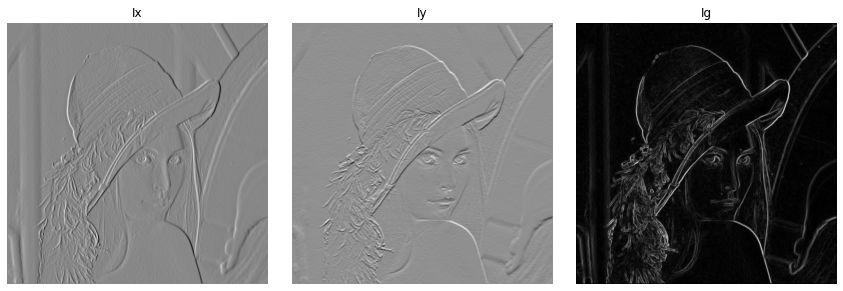

In [19]:
Ix, Iy, Ig = matrices_gradient(image_lena)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(Ix, cmap='gray')
plt.title("Ix")
plt.axis('off')  # Désactive les axes

plt.subplot(1, 3, 2)
plt.imshow(Iy, cmap='gray')
plt.title("Iy")
plt.axis('off')  # Désactive les axes

plt.subplot(1, 3, 3)
plt.imshow(Ig, cmap='gray')
plt.title("Ig")
plt.axis('off')  # Désactive les axes

plt.tight_layout()
plt.show()

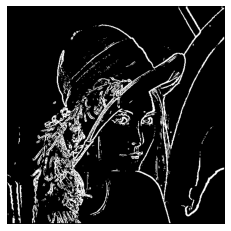

In [17]:
im_contours_lena = image_contours_gradient(image_lena, 100)

plt.axis('off')  # Désactive les axes
plt.imshow(im_contours_lena, cmap='gray')

In [21]:
min_seuil, max_seuil = seuillage_gradient(image_lena)
print('Seuil : [', min_seuil, ', ', max_seuil, ']')

Seuil : [ 0.0 ,  590.1660783203318 ]


### Détection des points d’intérêt

In [32]:
def harris_corner_detection(image, k=0.04, window_size=3):
    sigma=1.0

    # 1. Calculer les dérivées en x et y de l'image
    Ix = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    Iy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)

    # 2. Calculer les produits de dérivées
    Ix2 = Ix * Ix
    Iy2 = Iy * Iy
    Ixy = Ix * Iy

    # 3. Appliquer la convolution par un filtre Gaussien si nécessaire
    kernel = np.outer(cv2.getGaussianKernel(window_size, sigma), cv2.getGaussianKernel(window_size, sigma))
    Ix2 = convolve2d(Ix2, kernel, mode='same', boundary='wrap')
    Iy2 = convolve2d(Iy2, kernel, mode='same', boundary='wrap')
    Ixy = convolve2d(Ixy, kernel, mode='same', boundary='wrap')

    # 4. Calculer la réponse Harris
    det_M = Ix2 * Iy2 - Ixy**2
    trace_M = Ix2 + Iy2
    R = det_M - k * (trace_M**2)

    return R

def detect_corners(image, k=0.04):
    coins = np.zeros((image.shape[0], image.shape[1]))

    R = harris_corner_detection(image, k)

    # Trouver les coins en trouvant les maxima locaux de R
    corner_threshold = 0.01 * R.max()
    corners = np.where(R > corner_threshold)

    # Dessiner les coins sur l'image originale
    image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    coins[corners] = 1  # Marquer les coins

    return(coins)

In [33]:
# Exemple d'utilisation
image_path = 'img/triangle1.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image_coins = detect_corners(image)

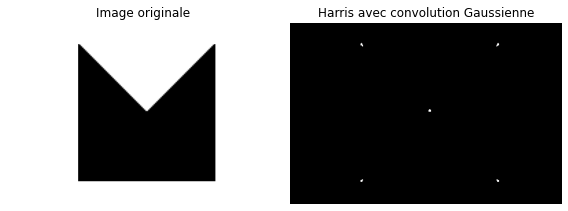

In [34]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Image originale")
plt.axis('off')  # Désactive les axes

plt.subplot(1, 2, 2)
plt.imshow(image_coins, cmap='gray')
plt.title('Harris avec convolution Gaussienne')
plt.axis('off')  # Désactive les axes

plt.tight_layout()
plt.show()

In [51]:
# Exemple d'utilisation
image_path = 'img/cameraman.tif'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image_coins = detect_corners(image, 0.001)

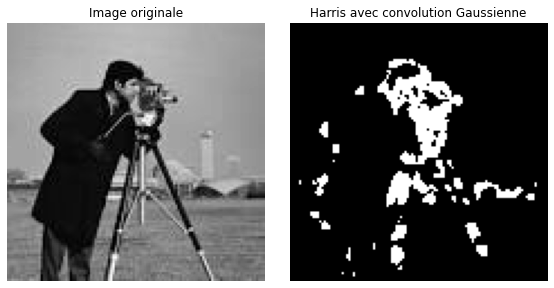

In [52]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Image originale")
plt.axis('off')  # Désactive les axes

plt.subplot(1, 2, 2)
plt.imshow(image_coins, cmap='gray')
plt.title('Harris avec convolution Gaussienne')
plt.axis('off')  # Désactive les axes

plt.tight_layout()
plt.show()